# Dynamical decoupling of a non-Markovian environment


### Introduction

Followings https://journals.aps.org/pra/pdf/10.1103/PhysRevA.58.2733 we consider an example of dynamical decoupling.
We choose a drive which performs pi rotations, interspersed with short periods where the bath causes dephasing.


In [1]:
%pylab inline
from qutip import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip.ipynbtools import HTMLProgressBar

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from heom.heom_fmotd import BosonicHEOMSolver as BosonicHEOMSolver

from heom.heom_fmotd_py import BosonicHEOMSolver as BosonicHEOMSolverPy

In [5]:

def coth(x):
    """
    coth function
    """
    return 1./np.tanh(x)

def cot(x):
    return 1./np.tan(x)


def J0(energy):
    #underdamped brownian oscillator
    return 2 * lam * gamma * (energy)/(((energy**2) + (gamma**2)))
def nbs(energy,Temperature):
    beta=1./Temperature
    
    return 1./(np.exp(energy*beta) - 1.)

#spectral density/w at w=0
def J02(energy):
    #underdamped brownian oscillator
    return 2 * lam * gamma /( ((gamma**2)))

Text(0, 0.5, 'J')

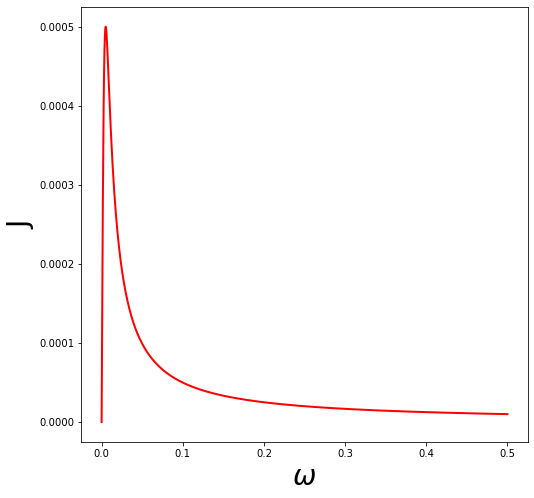

In [6]:
#A weakly coupled but very underdamped environment is the easiest to dynamically decouple.



pref = 1.
Nk = 3

Q = sigmaz()
T = .05
beta = 1./T

lam = 0.0005
gamma = 0.005



wlist = np.linspace(0, 0.5, 1000)
pref = 1.

J = [w * 2 * lam * gamma / ((gamma**2 + w**2)) for w in wlist]


fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(wlist, J, 'r', linewidth=2)
axes.set_xlabel(r'$\omega$', fontsize=28)
axes.set_ylabel(r'J', fontsize=28)



In [ ]:

wq = 1.

Hsys = wq * 0.5 * sigmaz()

NC = 10

ckAR = [pref * lam * gamma * (cot(gamma / (2 * T))) + 0.j]
ckAR.extend([(pref * 4 * lam * gamma * T *  2 * np.pi * k * T / (( 2 * np.pi * k * T)**2 - gamma**2))+0.j for k in range(1,Nk+1)])

vkAR = [gamma+0.j]
vkAR.extend([2 * np.pi * k * T + 0.j for k in range(1,Nk+1)])

ckAI = [pref * lam * gamma * (-1.0) + 0.j]

vkAI = [gamma+0.j]


NR = len(ckAR)
NI = len(ckAI)


ttotal=1000.
tlist2 = np.linspace(0, ttotal, 50000)


#Pure dephasing example: start with a superposition so there is something to dephase!

sup = (basis(2,1)+basis(2,0))/sqrt(2.)
initial_state2 = sup * sup.dag()


print(ckAR)


#With the HEOM solver we can explicitly include the time-dependent Hamiltonian.


#followings https://journals.aps.org/pra/pdf/10.1103/PhysRevA.58.2733
#We add the t_p dependence to the pulse design in equation 19/20

#This is a resonant drive on the qubit, which is applied for tp =  pi / V, where V
# is the magnitude of the drive, i.e, tp * V * 0.5 = pi/2.
#It then waits delta time steps, and then applies agian.
def drive(t):

    V = .5
    tp = pi/(V)

    delt = 20
    N = int(ttotal/(tp + delt))
    RF = 0.
    for n in arange(1,N+1):
        if t >= n*delt+(n-1)*tp:
            if t<=n*delt + n*tp:
                
                RF += V*cos(wq*(t-n*delt-(n-1)*tp))
    return RF

def drive2(t):

    V = .5
    tp = pi/(V)

    delt = 20
    N = int(ttotal/(tp + delt))
    RF = 0.
    for n in arange(1,N+1):
        if t >= n*delt+(n-1)*tp:
            if t<=n*delt + n*tp:
                
                RF += V*sin(wq*(t-n*delt-(n-1)*tp))
    return RF

optionsODE = Options(nsteps=1500, store_states=True,rtol=1e-12,atol=1e-12,max_step = 1/(20*wq))

H_d = [Hsys,[sigmax(), drive],[sigmay(), drive]]



Q2 = [Q for kk in range(NR+NI)]



print("test c code")
start = time.time()

resultHEOMOld = BosonicHEOMSolver(H_d, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
outputDDC  = resultHEOMOld.run(initial_state2,tlist2)
end = time.time()
print(end-start)

Q2 = [Q for kk in range(NR+NI)]

print("py code")
start = time.time()

resultHEOM = BosonicHEOMSolverPy(H_d, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
outputDDP  = resultHEOM.run(initial_state2,tlist2)
end = time.time()
print(end-start)


Q2 = [Q for kk in range(NR+NI)]

#print("check c code with qobjevo input")
#start = time.time()
#Hevo = QobjEvo([Hsys, [sigmax(), drive]])
#resultHEOMEvo = BosonicHEOMSolver(Hevo, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
#outputDDCQ  = resultHEOMEvo.run(initial_state2,tlist2)
#end = time.time()
#print(end-start)

print("check c code with no dynamical decoupling")

Q2 = [Q for kk in range(NR+NI)]

resultHEOM = BosonicHEOMSolver(Hsys, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
outputnoDD  = resultHEOM.run(initial_state2,tlist2)


#resultHEOM=heom_fmo.HSolverDLMultiBathsWithRes(id4state, Q,  lam0,Temperature, Ncc+1, Kk, gamma,res_list,renorm=True,options=optionsODE,bnd_cut_approx=True)
#outputQ2=resultHEOM.run(initial_state,tlist)

[(4.995832638723505e-05+0j), (1.591952677242856e-06+0j), (7.958251116734063e-07+0j), (5.305314086591749e-07+0j)]
test c code


In [ ]:


P12DDC=expect(outputDDC.states,basis(2,1)*basis(2,0).dag())
P12DDP=expect(outputDDP.states,basis(2,1)*basis(2,0).dag())
P12noDD=expect(outputnoDD.states,basis(2,1)*basis(2,0).dag())

fig, axes2 = subplots(1, 1, sharex=True, figsize=(12,6))



axes2.plot(tlist2, real(P12DDC), 'blue', linestyle='-', linewidth=2, label="P12 dd")
#axes2.plot(tlist2, real(P12DDP), 'blue', linestyle='-', linewidth=2, label="P12 dd")
axes2.plot(tlist2, real(P12noDD), 'orange', linestyle='--', linewidth=2, label="P12 no dd")

#P2HEOM=expect(output.states,P2)

P1noDD=expect(outputnoDD.states,basis(2,1)*basis(2,1).dag())

pulse = [drive(t) for t in tlist2]

fig, axes2 = subplots(1, 1, sharex=True, figsize=(12,6))

axes2.plot(tlist2, pulse, 'blue', linestyle='-', linewidth=2, label="P12 dd")

### Here move to an interaction picture, and make an RWA on the drive term.

This is slightly more convenient than the above example

In [ ]:

Hsys = 0.0 * sigmaz()


optionsODE = Options(nsteps=1500, store_states=True,rtol=1e-12,atol=1e-12,max_step = 1/(20*wq))

ttotal=400.
tlist2 = np.linspace(0, ttotal, 50000)

NC = 10

#followings https://journals.aps.org/pra/pdf/10.1103/PhysRevA.58.2733
#in this version we replace the drive with 
#pi/2 pulses, assuming interaction picture
#so h_sys = 0
#H_drive = V\sigma_x when t in {tp} period

def drive(t):
    V = .5
    tp = pi/(2.*V)  #we need Vtp = pi/2

    delt = 20.
    N = int(ttotal/(tp + delt))
    RF = 0.
    for n in arange(1,N+1):
        if t >= n*delt+(n-1)*tp:
            if t<=n*delt + n*tp:
                

                RF += V
    return RF




H_d = [Hsys,[sigmax(), drive]]



Q2 = [Q for kk in range(NR+NI)]

resultHEOM = BosonicHEOMSolver(H_d, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
outputDD  = resultHEOM.run(initial_state2,tlist2)





H_d = [Hsys,[0.*sigmax(), drive]]



Q2 = [Q for kk in range(NR+NI)]

resultHEOM = BosonicHEOMSolver(H_d, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
outputnoDD  = resultHEOM.run(initial_state2,tlist2)




In [ ]:

Hsys = 0.0 * sigmaz()


NC = 10

#followings https://journals.aps.org/pra/pdf/10.1103/PhysRevA.58.2733
#in this version we replace the drive with 
#pi/2 pulses, assuming interaction picture
#so h_sys = 0
#H_drive = V\sigma_x when t in {tp} period
#note in reality RWA will break down if V approaches wq.

def driveslow(t):
    V = .01
    tp = pi/(2.*V)  #here i need factor of 1/2 for RWA

    delt = 20.
    N = int(ttotal/(tp + delt))
    RF = 0.
    for n in arange(1,N+1):
        if t >= n*delt+(n-1)*tp:
            if t<=n*delt + n*tp:
                

                RF += V
    return RF




H_d = [Hsys,[sigmax(), driveslow]]



Q2 = [Q for kk in range(NR+NI)]

resultHEOM = BosonicHEOMSolver(H_d, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
outputDDslow  = resultHEOM.run(initial_state2,tlist2)





H_d = [Hsys,[0.*sigmax(), driveslow]]



Q2 = [Q for kk in range(NR+NI)]

resultHEOM = BosonicHEOMSolver(H_d, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
outputnoDDslow  = resultHEOM.run(initial_state2,tlist2)




In [ ]:
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['font.family'] = 'STIXGeneral' 
matplotlib.rcParams['mathtext.fontset'] =  'stix'

In [ ]:
#P2HEOM=expect(output.states,P2)


fig, axes = plt.subplots(2, 1, sharex=False, figsize=(12,10))



P12DD=expect(outputDD.states,basis(2,1)*basis(2,0).dag())
P12noDD=expect(outputnoDD.states,basis(2,1)*basis(2,0).dag())

P12DDslow=expect(outputDDslow.states,basis(2,1)*basis(2,0).dag())
P12noDDslow=expect(outputnoDDslow.states,basis(2,1)*basis(2,0).dag())


axes[0].plot(tlist2, real(P12DD), 'green', linestyle='-', linewidth=2, label="HEOM with fast DD")
axes[0].plot(tlist2, real(P12DDslow), 'blue', linestyle='-', linewidth=2, label="HEOM with slow DD")
axes[0].plot(tlist2, real(P12noDD), 'orange', linestyle='--', linewidth=2, label="HEOM no DD")


axes[0].locator_params(axis='y', nbins=6)
axes[0].locator_params(axis='x', nbins=6)


axes[0].set_ylabel(r"$\rho_{21}$")#, fontsize=20)

axes[0].legend()
axes[0].text(20,0.3,"(a)",fontsize=28)

pulse = [drive(t) for t in tlist2]
pulseslow = [driveslow(t) for t in tlist2]


axes[1].plot(tlist2, pulse, 'green', linestyle='-', linewidth=2, label="Drive fast")
axes[1].plot(tlist2, pulseslow, 'blue', linestyle='-', linewidth=2, label="Drive slow")
axes[1].legend()



axes[1].locator_params(axis='y', nbins=6)
axes[1].locator_params(axis='x', nbins=6)



#axes[1].set_xlim(200,600)
axes[1].set_xlabel(r'$t$ $(1/\epsilon)$')#, fontsize=20)
axes[1].set_ylabel(r'Drive pulse')#, fontsize=20)
#axes[1].legend(loc=0)

axes[1].text(0,0.4,"(b)",fontsize=28)

fig.tight_layout()
# fig.savefig("ddfig.pdf")